In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
# Load dataset
df = pd.read_csv("boxing_data.csv")

# List of numeric columns that should be converted
numeric_cols = [
    "ReachA","ReachB","HeightA","HeightB","WeightA","WeightB",
    "AgeA","AgeB","WinsA","WinsB","KOPercA","KOPercB",
    "RecentWinPercA","RecentWinPercB","DefensePercA","DefensePercB",
    "PunchAccuracyA","PunchAccuracyB","StrengthOfScheduleA","StrengthOfScheduleB",
    "TimeSinceLastFightA","TimeSinceLastFightB","Result"
]

# Convert to numeric (invalid entries become NaN)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [14]:
# Feature differences
df["ReachDiff"] = df["ReachA"] - df["ReachB"]
df["AgeDiff"] = df["AgeA"] - df["AgeB"]
df["HeightDiff"] = df["HeightA"] - df["HeightB"]
df["WeightDiff"] = df["WeightA"] - df["WeightB"]
df["KODiff"] = df["KOPercA"] - df["KOPercB"]
df["WinDiff"] = df["WinsA"] - df["WinsB"]

# Extra differences
df["RecentWinPercDiff"] = df["RecentWinPercA"] - df["RecentWinPercB"]
df["DefenseDiff"] = df["DefensePercA"] - df["DefensePercB"]
df["PunchAccDiff"] = df["PunchAccuracyA"] - df["PunchAccuracyB"]
df["SoSDiff"] = df["StrengthOfScheduleA"] - df["StrengthOfScheduleB"]
df["TimeSinceDiff"] = df["TimeSinceLastFightA"] - df["TimeSinceLastFightB"]

# Drop rows with missing results
df = df.dropna(subset=["Result"])

In [15]:
# Features and target
feature_cols = [
    "ReachDiff", "AgeDiff", "HeightDiff", "WeightDiff",
    "KODiff", "WinDiff", "RecentWinPercDiff",
    "DefenseDiff", "PunchAccDiff", "SoSDiff", "TimeSinceDiff"
]

X = df[feature_cols]
y = df["Result"]   # 1 = FighterA wins, 0 = FighterB wins

In [17]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model pipeline with scaling + RandomForest
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        class_weight="balanced",
        min_samples_split=5
    )
)

# Train model
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy: 0.7872340425531915


In [18]:
# Predictions
y_pred = model.predict(X_test)

# Confusion matrix & classification report
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Cross-validation for stability
scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation accuracy:", scores.mean())


Confusion Matrix:
 [[ 0  8]
 [ 2 37]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.82      0.95      0.88        39

    accuracy                           0.79        47
   macro avg       0.41      0.47      0.44        47
weighted avg       0.68      0.79      0.73        47



C:\Users\ruder\IdeaProjects\Boxing Match Predictor\venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation accuracy: 0.7609620721554118


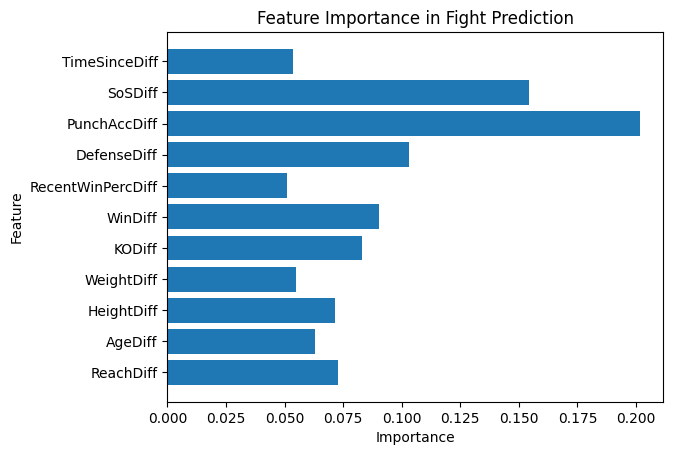

In [19]:
# Get RandomForest model from pipeline
rf = model.named_steps["randomforestclassifier"]

# Plot feature importances
importances = rf.feature_importances_
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Fight Prediction")
plt.show()

In [20]:
fighters_stats = {}

for _, row in df.iterrows():
    fighters_stats[row["FighterA"]] = {
        "Reach": row["ReachA"],
        "Age": row["AgeA"],
        "Height": row["HeightA"],
        "Weight": row["WeightA"],
        "KO%": row["KOPercA"],
        "Wins": row["WinsA"],
        "RecentWin%": row["RecentWinPercA"],
        "Defense%": row["DefensePercA"],
        "PunchAcc": row["PunchAccuracyA"],
        "SoS": row["StrengthOfScheduleA"],
        "TimeSince": row["TimeSinceLastFightA"]
    }
    fighters_stats[row["FighterB"]] = {
        "Reach": row["ReachB"],
        "Age": row["AgeB"],
        "Height": row["HeightB"],
        "Weight": row["WeightB"],
        "KO%": row["KOPercB"],
        "Wins": row["WinsB"],
        "RecentWin%": row["RecentWinPercB"],
        "Defense%": row["DefensePercB"],
        "PunchAcc": row["PunchAccuracyB"],
        "SoS": row["StrengthOfScheduleB"],
        "TimeSince": row["TimeSinceLastFightB"]
    }

In [21]:
def predict_fight(fighterA, fighterB, model, fighters_stats):
    statsA = fighters_stats[fighterA]
    statsB = fighters_stats[fighterB]

    features = {
        "ReachDiff": statsA["Reach"] - statsB["Reach"],
        "AgeDiff": statsA["Age"] - statsB["Age"],
        "HeightDiff": statsA["Height"] - statsB["Height"],
        "WeightDiff": statsA["Weight"] - statsB["Weight"],
        "KODiff": statsA["KO%"] - statsB["KO%"],
        "WinDiff": statsA["Wins"] - statsB["Wins"],
        "RecentWinPercDiff": statsA["RecentWin%"] - statsB["RecentWin%"],
        "DefenseDiff": statsA["Defense%"] - statsB["Defense%"],
        "PunchAccDiff": statsA["PunchAcc"] - statsB["PunchAcc"],
        "SoSDiff": statsA["SoS"] - statsB["SoS"],
        "TimeSinceDiff": statsA["TimeSince"] - statsB["TimeSince"]
    }

    X_pred = pd.DataFrame([features])
    pred = model.predict(X_pred)[0]
    prob = model.predict_proba(X_pred)[0]

    winner = fighterA if pred == 1 else fighterB
    confidence = prob[int(pred)]

    return winner, confidence

In [22]:
winner, confidence = predict_fight("Mike Tyson", "Muhammad Ali", model, fighters_stats)
print(f"Predicted winner: {winner} (Confidence: {confidence:.2f})")

Predicted winner: Mike Tyson (Confidence: 0.74)
